# Faktor yang mempengaruhi Data Emas

In Indonesia, the factors that can impact the gold price are:

1. Supply and demand: The relationship between the supply of and demand for gold is a key factor affecting its price.
2. Economic conditions: Economic conditions in Indonesia, such as inflation, recession, and interest rates, can affect the demand for gold and thus its price.
3. Political stability: Political stability and uncertainty in Indonesia can impact the demand for gold as a safe haven asset and thereby affect its price.
4. Currency fluctuations: Changes in the value of the Indonesian Rupiah against other major currencies can impact the price of gold.
5. Mining and production costs: The cost of mining and producing gold in Indonesia can impact its price.
6. Jewelry demand: The demand for gold in the jewelry industry can impact its price.
7. Technology demand: The demand for gold in technology applications can impact its price.
8. Central bank buying and selling: Central bank activities, such as buying and selling gold, can impact its price.

Reference:

KPMG. (2018). The gold market: A review of the supply chain, demand, and pricing. In KPMG International (Ed.), Global Precious Metals Handbook 2018 (pp. 12-24). KPMG International.
Torgler, B. (2017). Gold demand, supply, and price dynamics: A macroeconomic analysis. In Gold Demand, Supply and Price Dynamics (pp. 1-23). Emerald Publishing Limited.
Buiter, W. H. (2012). The economics of gold. Handbook of Commodity Markets and Investment (pp. 557-592). Springer.

# Persiapan Dataset

In [1]:
from prophet import Prophet
from statsmodels.tsa.stattools import grangercausalitytests
from statsforecast.adapters.prophet import AutoARIMAProphet

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

In [2]:
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('pystan').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('statsmodels').setLevel(logging.CRITICAL)

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.base.model")
warnings.filterwarnings("ignore") 

os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan/"

## Fungsi Tambahan

In [3]:
from datasetsforecast.losses import mse, mae, rmse

def eva_cro_val_sf(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [4]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_matrix(data, variables, maxlag, test='ssr_chi2test'):
    """
    This function returns two dataframes with results of granger causality tests for all pairs of variables.
    
    Parameters:
        data (DataFrame): The input data, containing all variables in the form of a time series.
        variables (list): List of all the variables to be tested.
        maxlag (int): Maximum number of lags to test.
        test (str): Test statistic to use (default is 'ssr_chi2test').
    
    Returns:
        tuple: Two dataframes, the first one contains the minimum lags where causality is found, and the second one contains the p-values at those lags.
    """
    num_vars = len(variables) # Number of variables
    df1 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    df2 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    
    # Loop through all variable combinations
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            result = None
            try:
                result = grangercausalitytests(data[[variables[i], variables[j]]], maxlag=maxlag, verbose=False)
                p_values = [round(result[lag][0][test][1], 10) for lag in range(1, maxlag+1)]
                min_lag = np.argmin(p_values)
                if min_lag == maxlag - 1 and p_values[min_lag] >= 0.05:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
                else:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = int(min_lag+1)
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = p_values[min_lag]
            except:
                df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
    return df1.T, df2.T

In [5]:
import statsmodels.api as sm

def make_stationary(data, max_diff = 10):
    """
    This function will return the stationary time series after difference has been applied and the number of differences applied.
    The input data should be a one-dimensional numpy array or pandas series.
    
    Parameters:
    data (numpy array or pandas series): The time series data that needs to be made stationary.
    max_diff (int, optional): The maximum number of differences to be applied. Defaults to 10.
    
    Returns:
    tuple: A tuple contains the stationary time series and the number of differences applied.
    """
    diff = 0
    result = sm.tsa.stattools.adfuller(data)
    while result[1] >= 0.05 and diff < max_diff:
        data = np.diff(data)
        result = sm.tsa.stattools.adfuller(data)
        diff += 1
    return data, diff


In [6]:
import pandas as pd

def date_to_ym(date_series):
    """
    Convert a pandas series of datetime dates into a series of strings in the format "YYYY-MM".
    
    Parameters:
        date_series (pd.Series): A pandas series of datetime dates.
    
    Returns:
        pd.Series: A pandas series of strings in the format "YYYY-MM".
    """
    datetime_series = pd.to_datetime(date_series)
    ym_series = datetime_series.dt.strftime("%Y-%m")
    return ym_series


In [7]:
from datetime import datetime

def indonesian_month_to_date(month_string_year_int):
    month_dict = {
        'Januari': '01',
        'Februari': '02',
        'Maret': '03',
        'April': '04',
        'Mei': '05',
        'Juni': '06',
        'Juli': '07',
        'Agustus': '08',
        'September': '09',
        'Oktober': '10',
        'November': '11',
        'Desember': '12'
    }
    split_string = month_string_year_int.split(" ")
    month = month_dict[split_string[0]]
    year = split_string[1]
    date_str = f"{year}-{month}"
    return date_str

In [8]:
def string_to_date_indo(date_string):
    """
    This function takes a date string in the format "dd month_name yyyy"
    (with support for Indonesian month names) and returns a datetime.date object.
    """
    
    # Dictionary to map Indonesian month names to English month names
    indonesian_months = {
        "Januari": "January",
        "Februari": "February",
        "Maret": "March",
        "April": "April",
        "Mei": "May",
        "Juni": "June",
        "Juli": "July",
        "Agustus": "August",
        "September": "September",
        "Oktober": "October",
        "November": "November",
        "Desember": "December"
    }
    
    # Replace the Indonesian month name in the input date_string with the corresponding English month name
    date_string = date_string.replace(date_string.split(" ")[1], indonesian_months[date_string.split(" ")[1]])
    
    # Parse the input date_string into a datetime.date object
    date_object = datetime.strptime(date_string, "%d %B %Y").date()
    
    # Return the datetime.date object
    return date_object

In [9]:
var_inter_model = {'tanggal':'ds',
                    'harga_emas':'y',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

var_model_inter = {'ds':'tanggal',
                    'y':'harga_emas',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

## Data Emas 

In [10]:
import numpy as np
import pandas as pd
from datetime import date, timedelta

In [11]:
from datetime import datetime as dtime
tabel_emas         = pd.read_json('data_emas.json')
tabel_emas.columns = ['tanggal','harga_emas']
# tabel_emas.tanggal
tabel_emas.tanggal = pd.to_datetime(tabel_emas.tanggal,unit='ms').dt.date

enddate = pd.to_datetime('2023-02-01').date()
tabel_emas = tabel_emas.loc[tabel_emas.tanggal < enddate]
tabel_emas = tabel_emas.iloc[tabel_emas.tanggal.drop_duplicates().index.tolist(),:]
tabel_emas = tabel_emas.reset_index(drop=True)
tabel_emas.tail(10)

,tanggal,harga_emas
3739,2023-01-22,1035000
3740,2023-01-23,1035000
3741,2023-01-24,1037000
3742,2023-01-25,1040000
3743,2023-01-26,1035000
3744,2023-01-27,1030000
3745,2023-01-28,1029000
3746,2023-01-29,1029000
3747,2023-01-30,1029000
3748,2023-01-31,1027000


## Data Kurs Dolar Ke Rupiah
* https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx


In [12]:
# data 
# https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx

data_kurs = pd.read_excel('Kurs Transaksi USD.xlsx',skiprows=4)
data_kurs = data_kurs.drop(['NO','Nilai'],axis=1)
data_kurs.Tanggal = pd.to_datetime(data_kurs.Tanggal,format='%m/%d/%Y %I:%M:%S %p')
data_kurs.Tanggal = data_kurs.Tanggal.dt.date
data_kurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Kurs Jual  3224 non-null   float64
 1   Kurs Beli  3224 non-null   float64
 2   Tanggal    3224 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.7+ KB


In [13]:
tabel_emas_kurs = pd.merge(tabel_emas, data_kurs,left_on='tanggal',right_on='Tanggal')
tabel_emas_kurs = tabel_emas_kurs.drop(['Tanggal'],axis=1)
tabel_emas_kurs["month_year"] = date_to_ym(tabel_emas_kurs.tanggal)
tabel_emas_kurs

,tanggal,harga_emas,Kurs Jual,Kurs Beli,month_year
0,2010-01-04,408000,9377.00,9283.00,2010-01
1,2010-01-05,410000,9355.00,9261.00,2010-01
2,2010-01-06,410000,9355.00,9261.00,2010-01
3,2010-01-07,412000,9274.00,9182.00,2010-01
4,2010-01-08,410000,9286.00,9194.00,2010-01
...,...,...,...,...,...
3198,2023-01-25,1040000,15004.65,14855.35,2023-01
3199,2023-01-26,1035000,15032.79,14883.21,2023-01
3200,2023-01-27,1030000,15038.82,14889.18,2023-01
3201,2023-01-30,1029000,15052.89,14903.11,2023-01


In [14]:
tabel_emas_kurs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3203 entries, 0 to 3202
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tanggal     3203 non-null   object 
 1   harga_emas  3203 non-null   int64  
 2   Kurs Jual   3203 non-null   float64
 3   Kurs Beli   3203 non-null   float64
 4   month_year  3203 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 150.1+ KB


## Data Inflasi
* https://www.bi.go.id/en/statistik/indikator/data-inflasi.aspx

In [15]:
data_inflasi = pd.read_excel("Data Inflasi.xlsx",skiprows=4)
data_inflasi = data_inflasi.iloc[:,:3]
data_inflasi = data_inflasi.drop('No',axis=1)
data_inflasi.Period = data_inflasi.Period.apply(lambda x: indonesian_month_to_date(x))
data_inflasi["Inflation Data"] = data_inflasi["Inflation Data"].apply(lambda x: float(x.split()[0])/100)
data_inflasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          157 non-null    object 
 1   Inflation Data  157 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [16]:
tabel_emas_kurs_inflasi = tabel_emas_kurs.merge(data_inflasi,left_on="month_year",
                                                right_on="Period",how='left')
tabel_emas_kurs_inflasi = tabel_emas_kurs_inflasi.drop(['Period'],axis=1)
tabel_emas_kurs_inflasi

,tanggal,harga_emas,Kurs Jual,Kurs Beli,month_year,Inflation Data
0,2010-01-04,408000,9377.00,9283.00,2010-01,0.0372
1,2010-01-05,410000,9355.00,9261.00,2010-01,0.0372
2,2010-01-06,410000,9355.00,9261.00,2010-01,0.0372
3,2010-01-07,412000,9274.00,9182.00,2010-01,0.0372
4,2010-01-08,410000,9286.00,9194.00,2010-01,0.0372
...,...,...,...,...,...,...
3198,2023-01-25,1040000,15004.65,14855.35,2023-01,0.0528
3199,2023-01-26,1035000,15032.79,14883.21,2023-01,0.0528
3200,2023-01-27,1030000,15038.82,14889.18,2023-01,0.0528
3201,2023-01-30,1029000,15052.89,14903.11,2023-01,0.0528


## Data Suku Bunga
* https://www.bi.go.id/id/statistik/indikator/bi-7day-rr.aspx
* BI 7-day (Reverse) Repo Rate

In [17]:
suku_bunga_df_jan_2023 = pd.read_excel('Interest_Rate_Januari_2023.xlsx',skiprows=4)
suku_bunga_df_jan_2023 = suku_bunga_df_jan_2023.iloc[:,1:3]
suku_bunga_df_jan_2023.Tanggal = suku_bunga_df_jan_2023.Tanggal.apply(lambda x: indonesian_month_to_date(x.split()[1] + ' ' + x.split()[2]))
suku_bunga_df_jan_2023['BI-7Day-RR'] = suku_bunga_df_jan_2023['BI-7Day-RR'].apply(lambda x : float(x.split()[0]))
suku_bunga_df_jan_2023.columns = ['date_month_indo','suku_bunga_bi']
suku_bunga_df_jan_2023

,date_month_indo,suku_bunga_bi
0,2023-01,5.75


In [18]:
suku_bunga_df = pd.read_csv('Interest Rate.csv',delimiter=";")

suku_bunga_df = suku_bunga_df.drop(['nama_item_vertical_variabel','nama_variabel_turunan'],axis=1)
suku_bunga_df = suku_bunga_df.iloc[:,1:]


suku_bunga_df['date_month'] = suku_bunga_df['nama_turunan_tahun'] + ' ' + suku_bunga_df['nama_tahun'].astype('string')
suku_bunga_df = suku_bunga_df[['date_month','data_content']]
suku_bunga_df = suku_bunga_df.rename(columns= {'date_month':'date_month','data_content':'suku_bunga_bi'})
suku_bunga_df['date_month_indo'] = suku_bunga_df['date_month'].apply(lambda x : indonesian_month_to_date(x))
suku_bunga_df = suku_bunga_df[['date_month_indo','suku_bunga_bi']]
suku_bunga_df = pd.concat([suku_bunga_df,suku_bunga_df_jan_2023],axis=0)

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi.merge(suku_bunga_df,
                                                                left_on="month_year",
                                                                right_on="date_month_indo",how='left')

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest.drop(['month_year','date_month_indo'],axis=1)
tabel_emas_kurs_inflasi_interest.columns = ['tanggal','harga_emas','kurs_jual','kurs_beli','data_inflasi','suku_bunga_bi']
tabel_emas_kurs_inflasi_interest

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.00,9283.00,0.0372,6.50
1,2010-01-05,410000,9355.00,9261.00,0.0372,6.50
2,2010-01-06,410000,9355.00,9261.00,0.0372,6.50
3,2010-01-07,412000,9274.00,9182.00,0.0372,6.50
4,2010-01-08,410000,9286.00,9194.00,0.0372,6.50
...,...,...,...,...,...,...
3198,2023-01-25,1040000,15004.65,14855.35,0.0528,5.75
3199,2023-01-26,1035000,15032.79,14883.21,0.0528,5.75
3200,2023-01-27,1030000,15038.82,14889.18,0.0528,5.75
3201,2023-01-30,1029000,15052.89,14903.11,0.0528,5.75


In [19]:
tabel_emas_kurs_inflasi_interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3203 entries, 0 to 3202
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tanggal        3203 non-null   object 
 1   harga_emas     3203 non-null   int64  
 2   kurs_jual      3203 non-null   float64
 3   kurs_beli      3203 non-null   float64
 4   data_inflasi   3203 non-null   float64
 5   suku_bunga_bi  3203 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 175.2+ KB


## Grafik

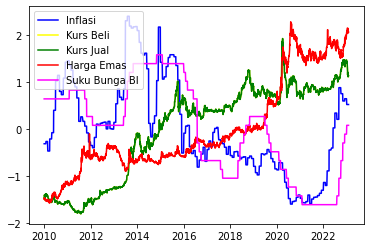

In [20]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()

fig, ax = plt.subplots()
# standardisasi agar bisa melihat apa pengarhus diantara keduanya
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["data_inflasi"]]),label="Inflasi",color="blue")
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["kurs_beli"]]),label="Kurs Beli",color="yellow")
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["kurs_jual"]]),label="Kurs Jual",color="green")
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["harga_emas"]]),label="Harga Emas",color="red")
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["suku_bunga_bi"]]),label="Suku Bunga BI",color="magenta")

plt.legend()
plt.show()

Ada Beberapa kesimpulan dari grafik ini
* Ada pengaruh antara Harga Emas dan Kurs Jual
* Ada Pengaruh antara harga emas dan inflasi pada tahun 2010 hingga 2017
* Tetapi, ada hal yang berpengaruh negatif pada inflasi dari 2017 hingga januari 2022
* kemunkinan kurang berpengaruh antara inflasi dengan kurs jual
* kurs jual dan kurs beli memiliki kesamaan grafik , maka mereka cenderung menyatu

## Stationary 

## Statistic

In [21]:
min_lag_df,test_result_lag  = granger_causality_matrix(tabel_emas_kurs_inflasi_interest,
                                        tabel_emas_kurs_inflasi_interest.drop('tanggal',axis=1).columns.tolist(),
                                        maxlag=100)
print(f'min_lag_df\n{min_lag_df}\n')
print(f'test_result_lag\n{test_result_lag}')
# 2menit

min_lag_df
                 harga_emas_x  kurs_jual_x  kurs_beli_x  data_inflasi_x  \
harga_emas_y              0.0          0.0          0.0             0.0   
kurs_jual_y               2.0          0.0          0.0             0.0   
kurs_beli_y               2.0         84.0          0.0             0.0   
data_inflasi_y            2.0         89.0         89.0             0.0   
suku_bunga_bi_y          56.0          7.0          7.0             1.0   

                 suku_bunga_bi_x  
harga_emas_y                 0.0  
kurs_jual_y                  0.0  
kurs_beli_y                  0.0  
data_inflasi_y               0.0  
suku_bunga_bi_y              0.0  

test_result_lag
                 harga_emas_x  kurs_jual_x  kurs_beli_x  data_inflasi_x  \
harga_emas_y         0.000000     0.000000     0.000000        0.000000   
kurs_jual_y          0.000000     0.000000     0.000000        0.000000   
kurs_beli_y          0.000000     0.068622     0.000000        0.000000   
data_inflas

In [22]:
tabel_emas_kurs_inflasi_interest.tanggal[tabel_emas_kurs_inflasi_interest.tanggal.duplicated()]

Series([], Name: tanggal, dtype: object)

In [23]:
tabel_emas_kurs_inflasi_interest[:64]

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.0,9283.0,0.0372,6.5
1,2010-01-05,410000,9355.0,9261.0,0.0372,6.5
2,2010-01-06,410000,9355.0,9261.0,0.0372,6.5
3,2010-01-07,412000,9274.0,9182.0,0.0372,6.5
4,2010-01-08,410000,9286.0,9194.0,0.0372,6.5
...,...,...,...,...,...,...
59,2010-03-31,395000,9161.0,9069.0,0.0343,6.5
60,2010-04-01,397000,9120.0,9030.0,0.0391,6.5
61,2010-04-05,399000,9100.0,9010.0,0.0391,6.5
62,2010-04-06,399000,9090.0,9000.0,0.0391,6.5


In [24]:
tabel_emas_kurs_inflasi_interest.drop_duplicates().tanggal.head(10)

0    2010-01-04
1    2010-01-05
2    2010-01-06
3    2010-01-07
4    2010-01-08
5    2010-01-11
6    2010-01-12
7    2010-01-13
8    2010-01-14
9    2010-01-15
Name: tanggal, dtype: object

In [25]:
tabel_emas_kurs_inflasi_interest

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.00,9283.00,0.0372,6.50
1,2010-01-05,410000,9355.00,9261.00,0.0372,6.50
2,2010-01-06,410000,9355.00,9261.00,0.0372,6.50
3,2010-01-07,412000,9274.00,9182.00,0.0372,6.50
4,2010-01-08,410000,9286.00,9194.00,0.0372,6.50
...,...,...,...,...,...,...
3198,2023-01-25,1040000,15004.65,14855.35,0.0528,5.75
3199,2023-01-26,1035000,15032.79,14883.21,0.0528,5.75
3200,2023-01-27,1030000,15038.82,14889.18,0.0528,5.75
3201,2023-01-30,1029000,15052.89,14903.11,0.0528,5.75


In [26]:
from statsmodels.tsa.stattools import pacf,acf
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# pacfku = pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=1648)
acfku = acf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=3298)

data_acf = pd.DataFrame({'acf':acfku})
print(data_acf.sort_values('acf')[2174:2176])

# percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
# result = seasonal_decompose(percobaan)
# result

           acf
1028  0.027348
1027  0.027730


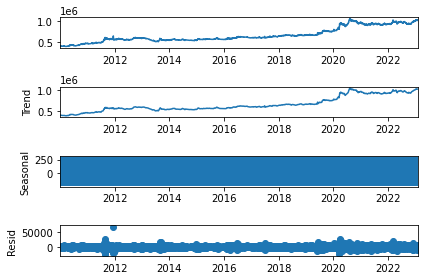

In [27]:
percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
percobaan.tanggal = pd.to_datetime(percobaan.tanggal)
percobaan = percobaan.set_index('tanggal')
percobaan = percobaan.asfreq('B')
percobaan = percobaan.interpolate(method='spline',order=5,axis=0)
result = seasonal_decompose(percobaan,)
result.plot()
plt.show()

# Py caret

In [28]:
from pycaret.time_series import *

tabel_emas_pycaret = tabel_emas.copy()
tabel_emas_pycaret.tanggal = pd.to_datetime(tabel_emas_pycaret.tanggal)
tabel_emas_pycaret.tanggal = tabel_emas_pycaret.tanggal.dt.to_period('B')
tabel_emas_pycaret = tabel_emas_pycaret.drop_duplicates('tanggal')
tabel_emas_pycaret = tabel_emas_pycaret.set_index('tanggal')

idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
tabel_emas_pycaret

pycaret_time_series = TSForecastingExperiment()
pycaret_time_series.setup(data=tabel_emas_pycaret,
            target='harga_emas',
            numeric_imputation_target='drift',
            max_sp_to_consider=None)

In [ ]:
best = pycaret_time_series.compare_models()

In [ ]:
final_model = pycaret_time_series.tune_model(best)

In [ ]:
final_model_ts = pycaret_time_series.finalize_model(final_model)


# apa gitu

Index(['ds', 'AutoARIMA', 'AutoETS', 'HoltWinters', 'HistoricAverage', 'CES',
       'AutoTheta'],
      dtype='object')


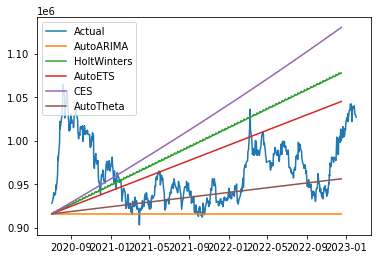

In [28]:
from statsforecast.models import (       
        MSTL,
        AutoARIMA,
        AutoETS,
        HoltWinters,
        HistoricAverage,
        AutoCES,
        AutoTheta,
)
from statsforecast import StatsForecast

from neuralforecast.auto import AutoNHITS


tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_kurs_inflasi_interest_uniq['unique_id'] = 0
tabel_emas_kurs_inflasi_interest_uniq['ds'] = tabel_emas_kurs_inflasi_interest_uniq['tanggal']
tabel_emas_kurs_inflasi_interest_uniq['y'] = tabel_emas_kurs_inflasi_interest_uniq['harga_emas']
tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest_uniq.drop(['harga_emas','tanggal'],axis=1)

cobain = tabel_emas_kurs_inflasi_interest_uniq[['unique_id','ds','y']]


y_train = cobain[:int(len(cobain)*0.8)]
y_test = cobain[int(len(cobain)*0.8):]

modelan = StatsForecast(models=[AutoARIMA(),
                                AutoETS(),
                                HoltWinters(season_length=7),
                                HistoricAverage(),
                                AutoCES(),
                                AutoTheta(),
                                ],
                        freq='B')

modelan.fit(df=y_train)
y_predict = modelan.predict(h=len(y_test))

print(y_predict.columns)

plt.plot(y_test.ds,y_test.y,label='Actual')
plt.plot(y_predict.ds,y_predict.AutoARIMA,label='AutoARIMA')
plt.plot(y_predict.ds,y_predict.HoltWinters  ,label='HoltWinters')
plt.plot(y_predict.ds,y_predict.AutoETS  ,label='AutoETS')
plt.plot(y_predict.ds,y_predict.CES  ,label='CES')
plt.plot(y_predict.ds,y_predict.AutoTheta  ,label='AutoTheta')

plt.legend()
plt.show()

In [29]:
# from neuralforecast.auto import AutoNHITS
# from neuralforecast import NeuralForecast

# config_nhits = {
#     'input_size' :[1,7,30,90,120,365],
#     'max_steps' :[100],
# }


# nf = NeuralForecast(models=[AutoNHITS(h=len(y_test),config=config_nhits)], 
#                     freq='B')
# nf.fit(df=y_train)
# hasil = nf.predict()
# hasil

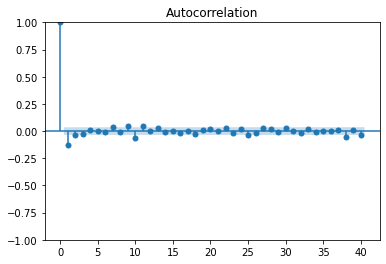

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=3298)
plot_acf(tabel_emas_kurs_inflasi_interest['harga_emas'].diff(periods=1).dropna(),lags=40)
plt.show()

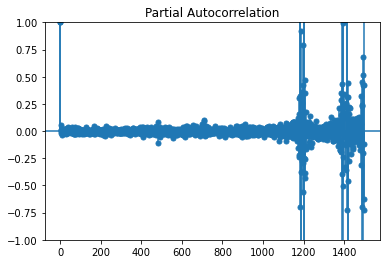

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=1500)
plt.show()

# Percobaan Prophet

12:19:55 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
Global seed set to 1
Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

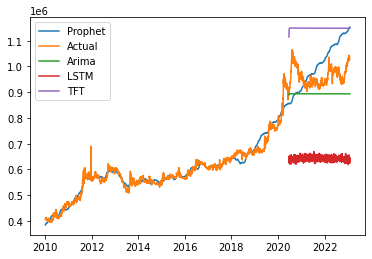

MAE With Prophet : 88594.4393078949
MAE With Arima   : 69836.40724307581
MAE With LSTM    : 321733.0861787453
MAE With TFT     : 184882.76195148486


In [41]:
from statsforecast import StatsForecast
from statsforecast.models import *

from neuralforecast.core import NeuralForecast,TFT,LSTM
from neuralforecast.auto import AutoTFT
from neuralforecast.losses.pytorch import (
    MAE,
    MAPE,
    MSE
)



from prophet import Prophet
from sklearn.metrics import mean_absolute_error


tabel_emas_prophet =tabel_emas.copy()
tabel_emas_prophet.columns = ['ds','y']
tabel_emas_prophet = tabel_emas_prophet.set_index('ds')
tabel_emas_prophet.index = pd.to_datetime(tabel_emas_prophet.index)

tabel_emas_prophet = tabel_emas_prophet[~tabel_emas_prophet.index.duplicated()]
tabel_emas_prophet = tabel_emas_prophet.asfreq('D')
tabel_emas_prophet = tabel_emas_prophet.reset_index()
tabel_emas_prophet['unique_id'] = 0
tabel_emas_prophet.y = tabel_emas_prophet.y.interpolate(method='spline',order=5)
# print(tabel_emas_prophet.head(10))

model_prophet = Prophet()

val_len = int(len(tabel_emas_prophet)*0.8)

y_train = tabel_emas_prophet[:val_len]
y_test  = tabel_emas_prophet[val_len:]

model_prophet.fit(y_train)

future = model_prophet.make_future_dataframe(periods=len(y_test))
forecast = model_prophet.predict(future)

model_arima = StatsForecast(models=[AutoARIMA()],
                 freq='D')
model_arima.fit(y_train)
forecast_arima = model_arima.predict(h=len(y_test))


nf = NeuralForecast(
                models=[LSTM(h=len(y_test),
                            max_steps=10,
                            loss=MSE()),
                        TFT(h=len(y_test),
                         input_size=202,
                         batch_size=4,
                         windows_batch_size=4,
                         max_steps=10)], 
                freq='D') 

nf.fit(y_train)
forecast_lstm = nf.predict()
plt.plot(forecast['ds'],forecast['yhat'],label='Prophet')
plt.plot(tabel_emas_prophet.ds,tabel_emas_prophet.y,label='Actual')
plt.plot(forecast_arima['ds'],forecast_arima['AutoARIMA'],label='Arima')
plt.plot(forecast_lstm['ds'],forecast_lstm['LSTM'],label='LSTM')
plt.plot(forecast_lstm['ds'],forecast_lstm['TFT'],label='TFT')
plt.legend()
plt.show()

print('MAE With Prophet :',mean_absolute_error(y_true=y_test.y, y_pred=forecast['yhat'][val_len:]))
print('MAE With Arima   :',mean_absolute_error(y_true=y_test.y, y_pred=forecast_arima.AutoARIMA))
print('MAE With LSTM    :',mean_absolute_error(y_true=y_test.y, y_pred=forecast_lstm.LSTM))
print('MAE With TFT     :',mean_absolute_error(y_true=y_test.y, y_pred=forecast_lstm.TFT))

In [33]:
# nilai_tft_mae = []
# input_sizenya = [i for i in range(1,366)]
# for i in range(1,366):
#     nf = NeuralForecast(
#                     models=[TFT(h=len(y_test),
#                             input_size=i,
#                             batch_size=4,
#                             windows_batch_size=4,
#                             max_steps=2)], 
#                     freq='D') 

#     nf.fit(y_train)
#     forecast_lstm = nf.predict()
#     nilai_tft_mae.append(mean_absolute_error(y_true=y_test.y, y_pred=forecast_lstm.TFT))

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [34]:
nilai_tft_mae

[68551.83912069089,
 57751.659465879166,
 61124.35461493774,
 61272.15573941473,
 63021.98628334778,
 59365.84474307582,
 59279.66757257372,
 60728.420122259915,
 64213.98968292937,
 55654.134230523516,
 60441.18339370343,
 67551.04930636034,
 57768.787865460756,
 57064.8654674482,
 58910.959413577904,
 58104.69372320134,
 64629.63769548167,
 81654.27818972855,
 52570.64952864067,
 48964.700783870794,
 46489.50484624958,
 52737.404301130206,
 76458.0139376365,
 48270.429536485855,
 43226.03647640959,
 39580.73841618048,
 50096.30878596284,
 58330.29741043983,
 52858.07120751096,
 57877.43352445657,
 71254.72752288754,
 58858.850169331046,
 41933.44182669167,
 44580.146254033985,
 45070.55243865742,
 42899.1692562213,
 31150.316062172835,
 33209.41664050919,
 34414.426708500825,
 42432.28557669167,
 72076.66436912185,
 46774.43652773494,
 46581.92554447134,
 55068.18783931013,
 53951.24726661138,
 52617.383446004686,
 52129.912669331046,
 53334.539696004686,
 57037.90966200887,
 58385.2

In [35]:
min(nilai_tft_mae)

28446.03289967147

In [36]:
nilai_tft_mae.index(min(nilai_tft_mae))

201

In [38]:
jawaban = pd.DataFrame({'input_size':input_sizenya,'tft_mae':nilai_tft_mae})
jawaban.head()

,input_size,tft_mae
0,1,68551.839121
1,2,57751.659466
2,3,61124.354615
3,4,61272.155739
4,5,63021.986283


In [39]:
jawaban = jawaban.sort_values(by='tft_mae')
jawaban

,input_size,tft_mae
201,202,28446.032900
199,200,28451.532442
138,139,28456.941438
144,145,28469.082782
200,201,28482.411495
...,...,...
272,273,191581.199738
273,274,197253.250993
364,365,199222.718893
291,292,202239.572907


In [40]:
jawaban.to_csv('hyperparameter_size_TFT.csv')